<a href="https://colab.research.google.com/github/DJT777/ArabicRoots/blob/master/ENG_210_Technical_Writing_ProveIt_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


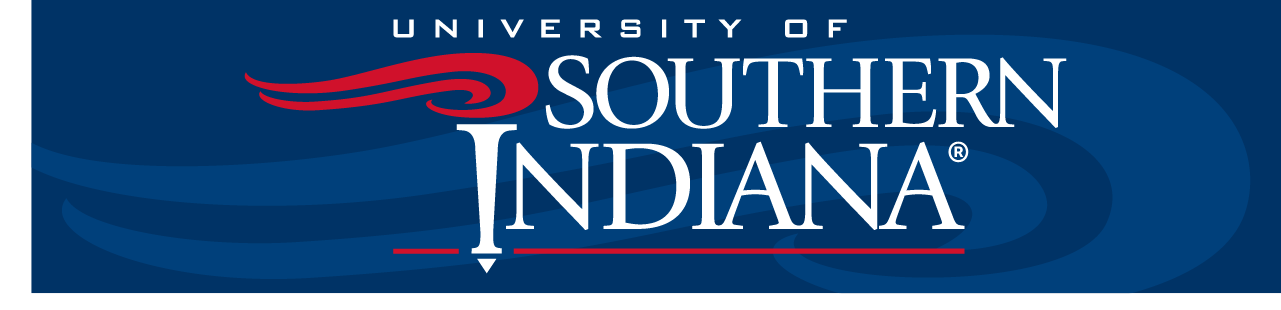




**Welcome to ProveIt! #1 (draft)** 
by Dylan James Tussey submitted for Dr. Santee's ENG 210 - Techinical Writing course at the University of Southern Indiana.

The goal of this notebook is to provide for you an introductory guide, with interactive code, that you can use to learn how to train and develop AI models. For our tutorial and guide, we are going to be training an AI that can determine if a picture contains a cat or a dog!


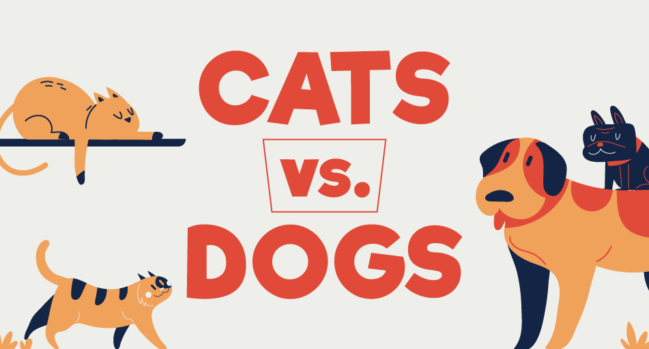

**Step 1: Import Your Libraries**

To begin we will need to import our programming libraries that we will need.

These include TensorFlow.... 


(TODO: will list all libraries with links here)

In [ ]:
import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from PIL import Image

print("Tensorflow: v{}".format(tf.__version__))
%matplotlib inline

Tensorflow: v2.8.2


**Step 2: Load Your Dataset**

We will be using Microsoft's Cat vs Dog dataset to train our classifier. The next line of code downloads the dataset for you, but we have also provided you a link to Microsoft's dataset.


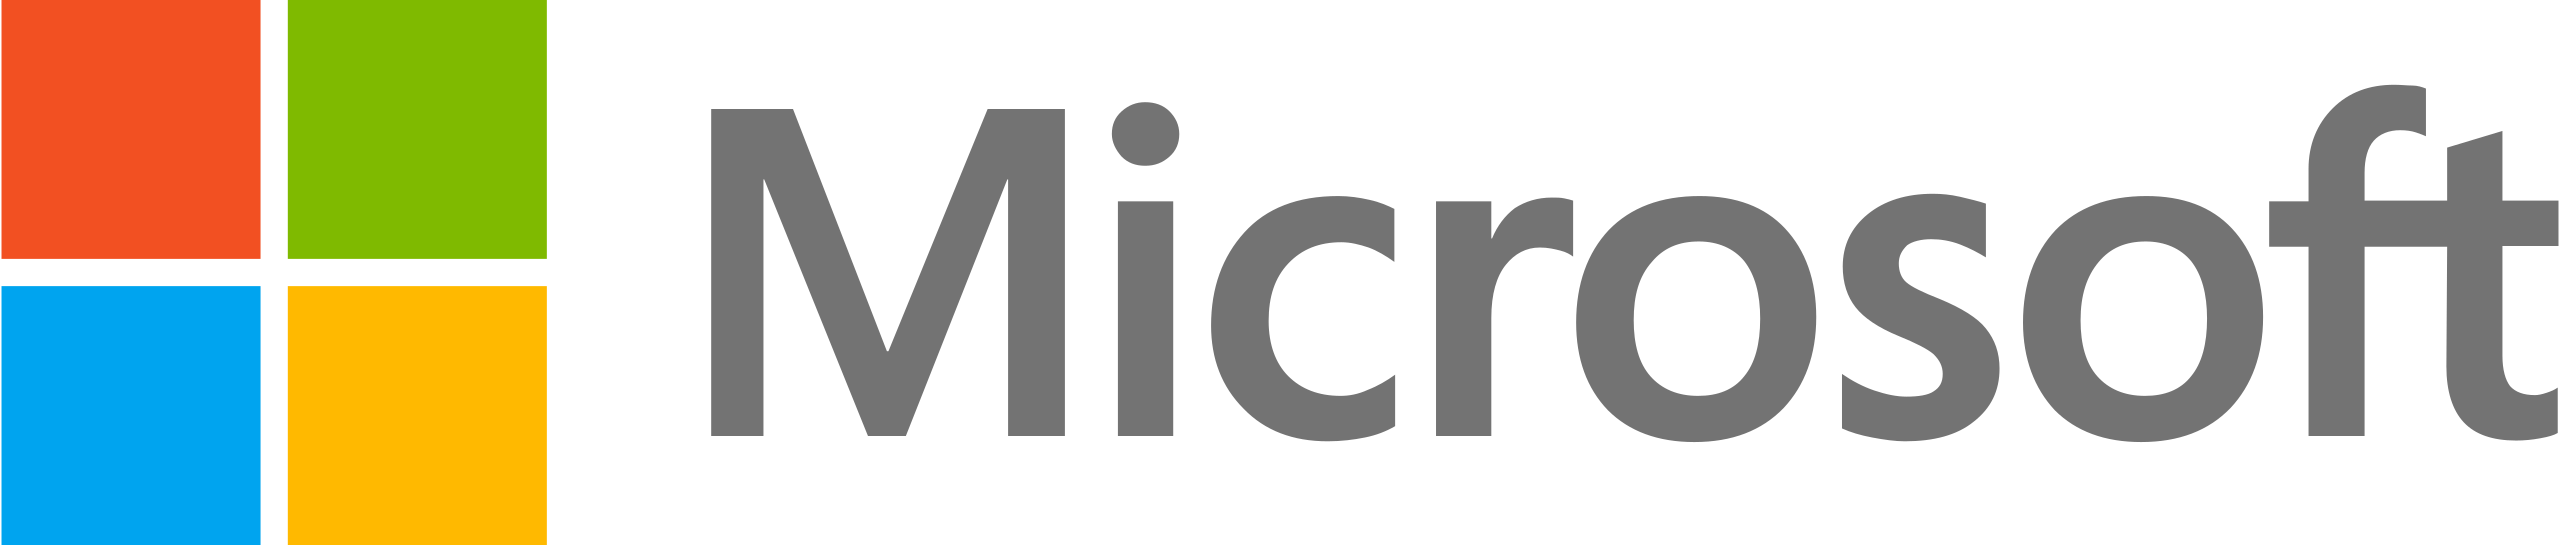


URL for dataset: https://www.microsoft.com/en-us/download/details.aspx?id=54765


In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2022-09-13 03:01:46--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.72.44.156, 2600:1413:b000:386::317f, 2600:1413:b000:390::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.72.44.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.3’

kagglecatsanddogs_5 100%[===================>] 786.67M   165MB/s    in 4.5s    

2022-09-13 03:01:50 (175 MB/s) - ‘kagglecatsanddogs_5340.zip.3’ saved [824887076/824887076]



Let's unzip the dataset.

In [ ]:
!unzip /content/kagglecatsanddogs_5340.zip

Let's look at how many pictures of cats and dogs we have.

In [ ]:
print("Number of cat images: " + str(len(os.listdir('/content/PetImages/Cat'))))
print("Number of dog images: " + str(len(os.listdir('/content/PetImages/Dog'))))

Number of cat images: 12501
Number of dog images: 12501


Sometimes datasets are not perfect and require cleaning. For the convenience of this tutorial we have included the removal images that could not be used for training.

In [ ]:

dir_name = "/content/PetImages/Cat/"
test = os.listdir(dir_name)

for item in test:
    if not item.endswith(".jpg") or item == '666.jpg':
        os.remove(os.path.join(dir_name, item))


dir_name = "/content/PetImages/Dog/"
test = os.listdir(dir_name)

for item in test:
    if not item.endswith(".jpg") or item == '11702.jpg':
        os.remove(os.path.join(dir_name, item))

It looks like we have an even number of images for both cats and dogs!

Let's take a look at some of the images we will use to train our model:

SHOWING CAT IMAGES:


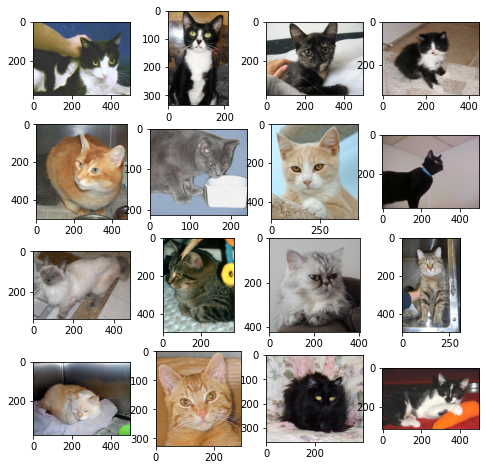

In [ ]:
print("SHOWING CAT IMAGES:")

cat_images = os.listdir('/content/PetImages/Cat')

fig=plt.figure(figsize=(8, 8)) 

for i, image in enumerate(cat_images):
  if (image.endswith('jpg')) and i <= 15:
    cur_img = mpimg.imread('/content/PetImages/Cat/' + image)
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(cur_img)


SHOWING DOG IMAGES:


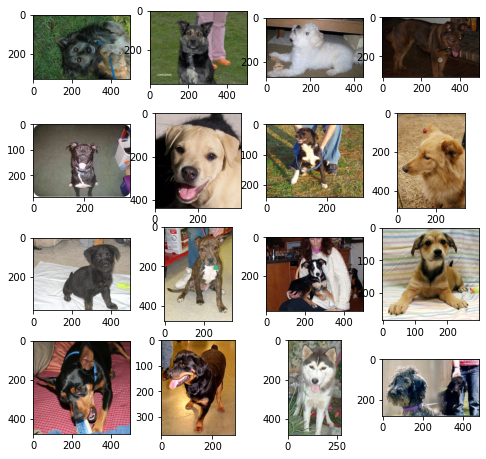

In [ ]:
print("SHOWING DOG IMAGES:")

dog_images = os.listdir('/content/PetImages/Dog')

fig=plt.figure(figsize=(8, 8)) 

for i, image in enumerate(cat_images):
  if (image.endswith('jpg')) and i <= 15:
    cur_img = mpimg.imread('/content/PetImages/Dog/' + image)
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(cur_img)


It looks like our dataset indeed does contain images of cats and dogs!

Now let's prepare our dataset in a way that can be used by our model.
'
**TODO: Elaborate on the use of ImageDataGenerator to intelligently sort through dataset.**

In [ ]:
train_dir = '/content/PetImages'
batch_size = 32


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='training')

val_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='validation')


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


**Step 3: Load Your Model**


For our model architecture we will be using ResNet50.

ResNet, short for Residual Network is a specific type of neural network that was introduced in 2015 by Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun in their paper “Deep Residual Learning for Image Recognition”.


Model Archictecure:

**(TODO: Elaboration on this model architecture)**


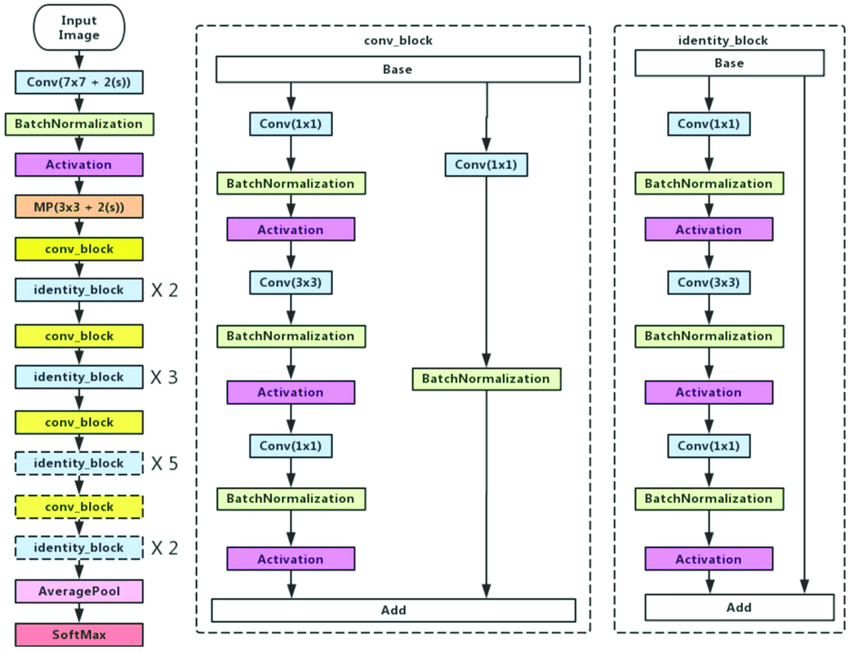

In [ ]:
ResNet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None)


We will also add on top of our model a layer that filters the results into either the category of 'Cat' or 'Dog'. This is the "Dense" layer added after the ResNet50 layer.

 **TO-DO: Discuss adding model layers for classification purposes**

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(2, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True



In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

**Step 4: Train Your Model**


Now that we have loaded our dataset, we will expose our data to the dataset. It will iterate through each image of the dataset and adjust its predictions to become more accurate as it learns what features tend to be either a Cat or a Dog.


Note: That for the purposes of the sake of time for this demo, we are only doing 5 cycles of training, known as epochs, but with more cycles we could achieve well over 90% accuracy.

In [ ]:
train_model = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.samples // batch_size,
    epochs = 5)

Epoch 1/5
 52/625 [=>............................] - ETA: 4:54 - loss: 12.1926 - accuracy: 0.5246

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

625/625 [==============================] - 390s 609ms/step - loss: 1.7766 - accuracy: 0.5861 - val_loss: 0.6930 - val_accuracy: 0.4914
Epoch 2/5
625/625 [==============================] - 378s 605ms/step - loss: 0.6650 - accuracy: 0.6262 - val_loss: 0.6916 - val_accuracy: 0.6552
Epoch 3/5
625/625 [==============================] - 379s 606ms/step - loss: 0.6352 - accuracy: 0.6489 - val_loss: 0.5922 - val_accuracy: 0.6821
Epoch 4/5
625/625 [==============================] - 378s 604ms/step - loss: 0.5976 - accuracy: 0.6831 - val_loss: 0.8387 - val_accuracy: 0.6831
Epoch 5/5
625/625 [==============================] - 381s 610ms/step - loss: 0.5561 - accuracy: 0.7169 - val_loss: 0.5128 - val_accuracy: 0.7456


**Step 5: Visualize Your Training Metrics**

Now that our model has completed training, let us take a look at its metrics. You should notice that is has become more accurate as time goes on, and that its loss is decreasing as well.

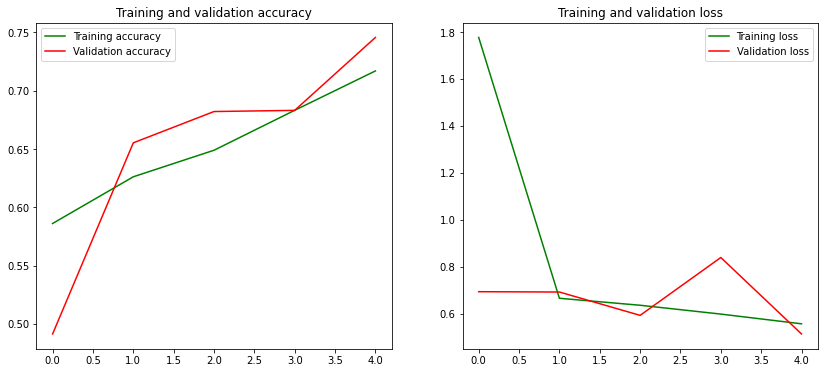

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

**Step 6: Use Your Model!**

We will now get to see how our model performs on images that it did* not * learn from. It seems to be pretty accurate!

**TODO: Expand this section.**

Found 4998 images belonging to 2 classes.
(1, 224, 224, 3)
(224, 224, 3)


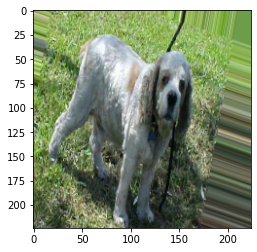

In [ ]:
rand_seed=123

test_gen= train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=1,
        shuffle=True,
        # Since we use categorical_crossentropy loss, we need binary labels
        class_mode='categorical',
        subset='validation')


batch=next(test_gen)  # returns the next batch of images and labels 
print(batch[0].shape) # batch[0] is the images, batch[1] are the labels
img=batch[0][0]   # this is the first image  batch[0][1] would be the next image
print(img.shape)
plt.imshow(img)   # shows the first image
img = np.reshape(img, (1, 224, 224, 3))

In [ ]:
labels = ['Cat', 'Dog']
yhat = model.predict(img)
pred_ind = np.argmax(yhat, axis=1)

print('This image is classified as a ' + labels[pred_ind[0]] + " with a confidence of " + str(max(yhat[0])*100)+"%")


This image is classified as a Dog with a confidence of 99.02338981628418%


**Conclusion**

You've succesfully trained a computer to not just *display* visual data, but to **understand** what it is displaying based on what it has seen before. This is a milestone in developing artificial intelligence. As, AI is defined as "Artificial intelligence is intelligence demonstrated by machines, as opposed to the natural intelligence displayed by animals including humans."

Our small program here has looked at thousands of pictures of cats and dogs, and learned how to visually distinguish between the two. The power of this technology can be used to analyze medical images to diagnose diseases faster and more accurate than humans, help robots visually understand their surroundings, and many other uses that are being discovered every day.

What an exciting time to live in!


TODO: Discuss the novelty and usefulness of classification AI, and the value of what was learned.


**Citation of Research Used:**
@misc{https://doi.org/10.48550/arxiv.1512.03385,
  doi = {10.48550/ARXIV.1512.03385},
  
  url = {https://arxiv.org/abs/1512.03385},
  
  author = {He, Kaiming and Zhang, Xiangyu and Ren, Shaoqing and Sun, Jian},
  
  keywords = {Computer Vision and Pattern Recognition (cs.CV), FOS: Computer and information sciences, FOS: Computer and information sciences},
  
  title = {Deep Residual Learning for Image Recognition},
  
  publisher = {arXiv},
  
  year = {2015},
  
  copyright = {arXiv.org perpetual, non-exclusive license}
}
